In [ ]:
import sys
import os
from pathlib import Path
import sqlite3
import pandas as pd
import sklearn
import numpy as np
import statsmodels as sm

project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) 
                     if (p / 'notebooks' / '01_data_acquisition.ipynb').exists()),
                    Path.cwd())
os.chdir(project_root)

DATABASE_PATH = str(project_root / "data" / "database" / "tb_data.db")

print(f" Project: {project_root}")
print(f" Database: {DATABASE_PATH}")


✓ Project: /Users/joshua/datascienceproject
✓ Database: /Users/joshua/datascienceproject/data/database/tb_data.db


In [93]:
conn = sqlite3.connect(DATABASE_PATH, timeout=30.0)
cursor = conn.cursor()

try:
    cursor.execute("DROP TABLE IF EXISTS final_data")
except sqlite3.OperationalError:
    pass


cursor.execute("""
    CREATE TABLE final_data AS
    SELECT 
        tb_avg.country_code,
        tb_avg.region_code,
        tb_avg.region_name,
        tb_avg.avg_number_of_cases,
        tb_avg.avg_number_of_deaths,
        wb.gdp_value_US,
        wb.poverty_rate,
        wb.population
    FROM (
        SELECT 
            country_code,
            region_code,
            region_name,
            AVG(number_of_cases) AS avg_number_of_cases,
            AVG(number_of_deaths) AS avg_number_of_deaths
        FROM unified_tb_data
        GROUP BY country_code, region_code, region_name
    ) tb_avg
    INNER JOIN country_data wb 
        ON tb_avg.country_code = wb.country_code
    ORDER BY tb_avg.country_code
""")

conn.commit()

df = pd.read_sql("SELECT * FROM final_data", conn)
conn.close()



In [94]:
df

,country_code,region_code,region_name,avg_number_of_cases,avg_number_of_deaths,gdp_value_US,poverty_rate,population
0,AFG,EMR,Eastern Mediterranean,20.0,14200.0,1.317308e+10,0.00,40750097.2
1,AGO,AFR,Africa,12240.0,23400.0,7.693571e+10,0.00,35650869.0
2,ALB,EUR,Europe,3.6,8.8,2.060312e+10,0.06,2777558.6
3,ARE,EMR,Eastern Mediterranean,2.8,69.0,4.637186e+11,0.00,10082379.8
4,ARG,AMR,Americas,986.0,614.0,5.568873e+11,1.42,45429342.0
...,...,...,...,...,...,...,...,...
168,VUT,WPR,Western Pacific,2.0,29.2,1.042001e+09,0.00,313191.6
169,YEM,EMR,Eastern Mediterranean,101.4,3460.0,0.000000e+00,0.00,38294386.4
170,ZAF,AFR,Africa,162800.0,24200.0,3.893483e+11,0.00,62332593.0
171,ZMB,AFR,Africa,20200.0,3840.0,2.466034e+10,14.34,20170972.2


In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_clean = df.copy()

df_clean['mortality_proportion'] = (df_clean['avg_number_of_deaths'] / df_clean['population']) * 100
df_clean['case_proportion'] = (df_clean['avg_number_of_cases'] / df_clean['population']) * 100

df_clean = df_clean.dropna(subset=['gdp_value_US', 'poverty_rate', 'region_code', 
                                    'avg_number_of_cases', 'avg_number_of_deaths', 'population'])

print(f"Data after initial cleaning: {df_clean.shape[0]} rows")

print(f"\nBefore imputation:")
print(f"  GDP zeros: {(df_clean['gdp_value_US'] == 0).sum()}")
print(f"  Poverty rate zeros: {(df_clean['poverty_rate'] == 0).sum()}")

for region in df_clean['region_code'].unique():
    region_mask = df_clean['region_code'] == region
    
    gdp_median = df_clean.loc[region_mask & (df_clean['gdp_value_US'] > 0), 'gdp_value_US'].median()
    if pd.notna(gdp_median) and gdp_median > 0:
        df_clean.loc[region_mask & (df_clean['gdp_value_US'] == 0), 'gdp_value_US'] = gdp_median
    else:
        gdp_median = df_clean.loc[df_clean['gdp_value_US'] > 0, 'gdp_value_US'].median()
        if pd.notna(gdp_median) and gdp_median > 0:
            df_clean.loc[region_mask & (df_clean['gdp_value_US'] == 0), 'gdp_value_US'] = gdp_median
    
    pov_median = df_clean.loc[region_mask & (df_clean['poverty_rate'] > 0), 'poverty_rate'].median()
    if pd.notna(pov_median) and pov_median > 0:
        df_clean.loc[region_mask & (df_clean['poverty_rate'] == 0), 'poverty_rate'] = pov_median
    else:
        pov_median = df_clean.loc[df_clean['poverty_rate'] > 0, 'poverty_rate'].median()
        if pd.notna(pov_median) and pov_median > 0:
            df_clean.loc[region_mask & (df_clean['poverty_rate'] == 0), 'poverty_rate'] = pov_median

print(f"\nAfter imputation:")
print(f"  GDP zeros: {(df_clean['gdp_value_US'] == 0).sum()}")
print(f"  Poverty rate zeros: {(df_clean['poverty_rate'] == 0).sum()}")

print(f"\nData after cleaning: {df_clean.shape[0]} rows")
print(f"\nCase proportion statistics (cases per 100 population):")
print(df_clean['case_proportion'].describe())
print(f"\nMortality proportion statistics (deaths per 100 population):")
print(df_clean['mortality_proportion'].describe())
print(f"\nGDP statistics:")
print(df_clean['gdp_value_US'].describe())
print(f"\nPoverty rate statistics:")
print(df_clean['poverty_rate'].describe())


Data after initial cleaning: 169 rows

Before imputation:
  GDP zeros: 4
  Poverty rate zeros: 73

After imputation:
  GDP zeros: 0
  Poverty rate zeros: 0

Data after cleaning: 169 rows

Case proportion statistics (cases per 100 population):
count    169.000000
mean       0.016675
std        0.043287
min        0.000007
25%        0.000250
50%        0.002115
75%        0.009080
max        0.350761
Name: case_proportion, dtype: float64

Mortality proportion statistics (deaths per 100 population):
count    169.000000
mean       0.013443
std        0.020447
min        0.000087
25%        0.000738
50%        0.004130
75%        0.018684
max        0.127456
Name: mortality_proportion, dtype: float64

GDP statistics:
count    1.690000e+02
mean     5.764702e+11
std      2.459908e+12
min      2.745343e+08
25%      1.698428e+10
50%      6.152062e+10
75%      3.072759e+11
max      2.558955e+13
Name: gdp_value_US, dtype: float64

Poverty rate statistics:
count    169.000000
mean       3.275325


In [96]:
label_encoder = LabelEncoder()
df_clean['region_code_encoded'] = label_encoder.fit_transform(df_clean['region_code'])

X = df_clean[['gdp_value_US', 'poverty_rate', 'region_code_encoded']].copy()
y_cases = df_clean['avg_number_of_cases'].copy()
y_deaths = df_clean['avg_number_of_deaths'].copy()
y_case_proportion = df_clean['case_proportion'].copy()
y_mortality_proportion = df_clean['mortality_proportion'].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"\nFeature names: {X.columns.tolist()}")
print(f"\nFeature ranges (before scaling):")
print(f"  GDP: {X['gdp_value_US'].min():.2e} to {X['gdp_value_US'].max():.2e}")
print(f"  Poverty rate: {X['poverty_rate'].min():.2f} to {X['poverty_rate'].max():.2f}")
print(f"  Region code: {X['region_code_encoded'].min()} to {X['region_code_encoded'].max()}")
print(f"\nTarget variables:")
print(f"  - Cases: {y_cases.shape[0]} values")
print(f"  - Deaths: {y_deaths.shape[0]} values")
print(f"  - Case Proportion (cases per 100 population): {y_case_proportion.shape[0]} values")
print(f"  - Mortality Proportion (deaths per 100 population): {y_mortality_proportion.shape[0]} values")



Features shape: (169, 3)

Feature names: ['gdp_value_US', 'poverty_rate', 'region_code_encoded']

Feature ranges (before scaling):
  GDP: 2.75e+08 to 2.56e+13
  Poverty rate: 0.02 to 27.54
  Region code: 0 to 5

Target variables:
  - Cases: 169 values
  - Deaths: 169 values
  - Case Proportion (cases per 100 population): 169 values
  - Mortality Proportion (deaths per 100 population): 169 values


## Linear Regression Models


In [107]:
from sklearn.preprocessing import StandardScaler

targets = {
    'Case Proportion (per 100)': y_case_proportion,
    'Mortality Proportion (per 100)': y_mortality_proportion
}

linear_results = {}

for target_name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=345)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    feature_names = X.columns.tolist()
    linear_results[target_name] = {
        'model': model,
        'scaler': scaler,
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'coefficients': dict(zip(feature_names, model.coef_)),
        'intercept': model.intercept_
    }
    
    print(f"{target_name} - Linear Regression:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  Coefficients (on scaled features):")
    for feature, coef in linear_results[target_name]['coefficients'].items():
        print(f"    {feature}: {coef:.6f}")
    print(f"  Intercept: {linear_results[target_name]['intercept']:.2f}")


Case Proportion (per 100) - Linear Regression:
  R² Score: 0.0816
  RMSE: 0.07
  MAE: 0.03
  Coefficients (on scaled features):
    gdp_value_US: -0.000451
    poverty_rate: 0.010539
    region_code_encoded: -0.004228
  Intercept: 0.01
Mortality Proportion (per 100) - Linear Regression:
  R² Score: 0.2819
  RMSE: 0.02
  MAE: 0.01
  Coefficients (on scaled features):
    gdp_value_US: -0.001823
    poverty_rate: 0.007801
    region_code_encoded: 0.004591
  Intercept: 0.01


## Random Forest

In [108]:
rf_results = {}

for target_name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=345)
    
    model = RandomForestRegressor(
        n_estimators=100, 
        random_state=345, 
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt'
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    feature_importance = dict(zip(X.columns, model.feature_importances_))
    
    rf_results[target_name] = {
        'model': model,
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'feature_importance': feature_importance
    }
    
    print(f"\n{target_name} - Random Forest:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  Feature Importance:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"    {feature}: {importance:.4f}")



Case Proportion (per 100) - Random Forest:
  R² Score: 0.0737
  RMSE: 0.07
  MAE: 0.03
  Feature Importance:
    poverty_rate: 0.3935
    region_code_encoded: 0.3277
    gdp_value_US: 0.2787

Mortality Proportion (per 100) - Random Forest:
  R² Score: 0.3311
  RMSE: 0.02
  MAE: 0.01
  Feature Importance:
    region_code_encoded: 0.3474
    gdp_value_US: 0.3402
    poverty_rate: 0.3124


## ANOVA Tests

In [ ]:
df_anova = df_clean.copy()

anova_results = {}

for target_name, target_col in [('Number of Cases', 'avg_number_of_cases'),
                                 ('Number of Deaths', 'avg_number_of_deaths'),
                                 ('Case Proportion (per 100)', 'case_proportion'),
                                 ('Mortality Proportion (per 100)', 'mortality_proportion')]:
    
    formula = f'{target_col} ~ C(region_code) + gdp_value_US + poverty_rate'
    model = ols(formula, data=df_anova).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    anova_results[target_name] = {
        'anova_table': anova_table,
        'model_summary': model.summary(),
        'rsquared': model.rsquared
    }
    
    print(f"\n{target_name} - ANOVA Results:")
    print(anova_table)
    print(f"\n  Model R²: {model.rsquared:.4f}")
    print(f"\n  Model p-value: {model.f_pvalue:.6f}")
    if model.f_pvalue < 0.05:
        print("   Model is statistically significant (p < 0.05)")
    else:
        print("   Model is not statistically significant (p >= 0.05)")



Number of Cases - ANOVA Results:
                      sum_sq     df         F    PR(>F)
C(region_code)  7.218211e+08    5.0  0.785148  0.561779
gdp_value_US    1.865531e+08    1.0  1.014599  0.315315
poverty_rate    8.845220e+08    1.0  4.810616  0.029719
Residual        2.960287e+10  161.0       NaN       NaN

  Model R²: 0.1261

  Model p-value: 0.002500
  ✓ Model is statistically significant (p < 0.05)

Number of Deaths - ANOVA Results:
                      sum_sq     df         F    PR(>F)
C(region_code)  2.139246e+10    5.0  6.711346  0.000010
gdp_value_US    1.818674e+09    1.0  2.852817  0.093150
poverty_rate    3.327312e+09    1.0  5.219303  0.023643
Residual        1.026377e+11  161.0       NaN       NaN

  Model R²: 0.1933

  Model p-value: 0.000011
  ✓ Model is statistically significant (p < 0.05)

Case Proportion (per 100) - ANOVA Results:
                  sum_sq     df         F    PR(>F)
C(region_code)  0.026263    5.0  3.642964  0.003777
gdp_value_US    0.000050    1

## Summary and Comparison


In [ ]:
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Target': [],
    'Model': [],
    'R² Score': [],
    'RMSE': []
})

for target_name in targets.keys():
    comparison_df = pd.concat([
        comparison_df,
        pd.DataFrame({
            'Target': [target_name, target_name, target_name],
            'Model': ['Linear Regression', 'Random Forest', 'ANOVA'],
            'R² Score': [
                linear_results[target_name]['r2'], 
                rf_results[target_name]['r2'],
                anova_results[target_name]['rsquared'] if target_name in anova_results else None
            ],
            'RMSE': [
                linear_results[target_name]['rmse'], 
                rf_results[target_name]['rmse'],
                None
            ]
        })
    ], ignore_index=True)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)

for target_name in targets.keys():
    print(f"\n{target_name}:")
    print(f"  Best Model: {'Random Forest' if rf_results[target_name]['r2'] > linear_results[target_name]['r2'] else 'Linear Regression'}")
    print(f"  Best R²: {max(linear_results[target_name]['r2'], rf_results[target_name]['r2']):.4f}")
    
    if target_name in anova_results:
        anova_p = anova_results[target_name]['anova_table'].loc['C(region_code)', 'PR(>F)']
        print(f"  Region Code Effect (ANOVA p-value): {anova_p:.6f}")
        if anova_p < 0.05:
            print("     Region code has a statistically significant effect")
        else:
            print("     Region code does not have a statistically significant effect")


MODEL COMPARISON SUMMARY

Model Performance Comparison:
                        Target             Model  R² Score     RMSE
     Case Proportion (per 100) Linear Regression  0.081601 0.067593
     Case Proportion (per 100)     Random Forest  0.073677 0.067884
     Case Proportion (per 100)             ANOVA  0.262580      NaN
Mortality Proportion (per 100) Linear Regression  0.281915 0.017718
Mortality Proportion (per 100)     Random Forest  0.331054 0.017101
Mortality Proportion (per 100)             ANOVA  0.323553      NaN

KEY FINDINGS:

Case Proportion (per 100):
  Best Model: Linear Regression
  Best R²: 0.0816
  Region Code Effect (ANOVA p-value): 0.003777
    ✓ Region code has a statistically significant effect

Mortality Proportion (per 100):
  Best Model: Random Forest
  Best R²: 0.3311
  Region Code Effect (ANOVA p-value): 0.000000
    ✓ Region code has a statistically significant effect


## Visualization

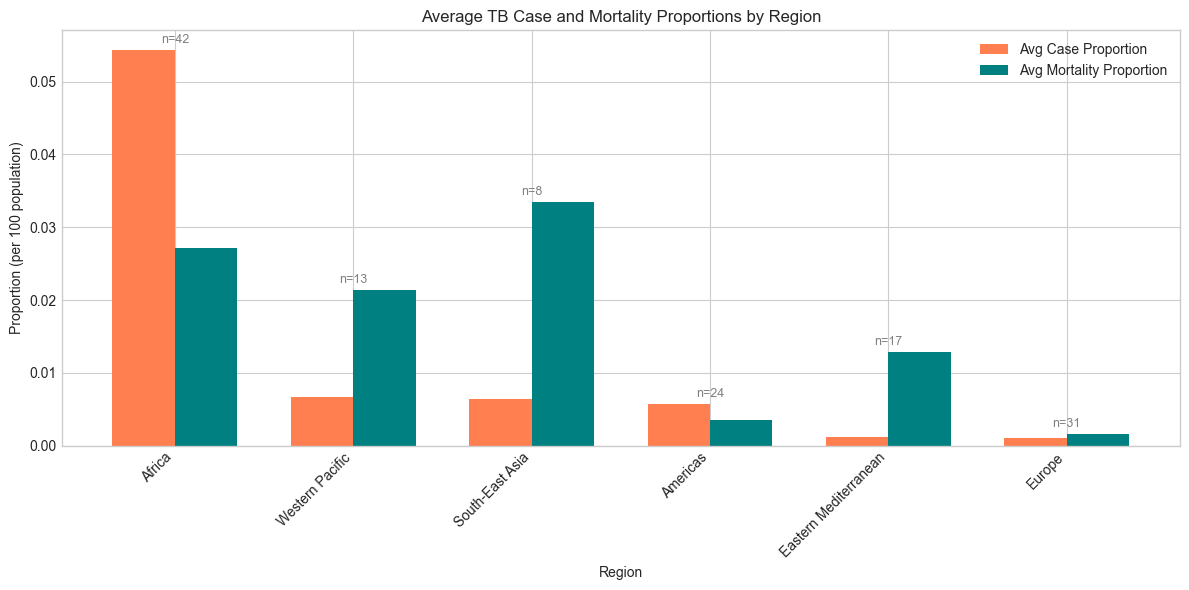

In [ ]:
import matplotlib as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

region_stats = df_clean.groupby('region_name').agg({
    'case_proportion': 'mean',
    'mortality_proportion': 'mean',
    'country_code': 'count'
}).rename(columns={'country_code': 'num_countries'}).sort_values('case_proportion', ascending=False)

x = np.arange(len(region_stats))
width = 0.35

bars1 = ax.bar(x - width/2, region_stats['case_proportion'], width, label='Avg Case Proportion', color='coral')
bars2 = ax.bar(x + width/2, region_stats['mortality_proportion'], width, label='Avg Mortality Proportion', color='teal')

ax.set_xlabel('Region')
ax.set_ylabel('Proportion (per 100 population)')
ax.set_title('Average TB Case and Mortality Proportions by Region')
ax.set_xticks(x)
ax.set_xticklabels(region_stats.index, rotation=45, ha='right')
ax.legend()

for i, (idx, row) in enumerate(region_stats.iterrows()): 
    ax.annotate(f'n={int(row["num_countries"])}', xy=(i, max(row['case_proportion'], row['mortality_proportion'])), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()